In [16]:
import numpy as np
import pickle as pkl
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn   
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def load_data(path):
    with open(path, 'rb') as f:
        data = pkl.load(f)
    return data

# Load the data
Interaction_matrices = load_data('small_matrices.pkl')
spectral_data = load_data('small_spectra.pkl')

print(Interaction_matrices.shape)
print(spectral_data.shape)

cpu
torch.Size([100, 4, 4])
torch.Size([100, 2001])


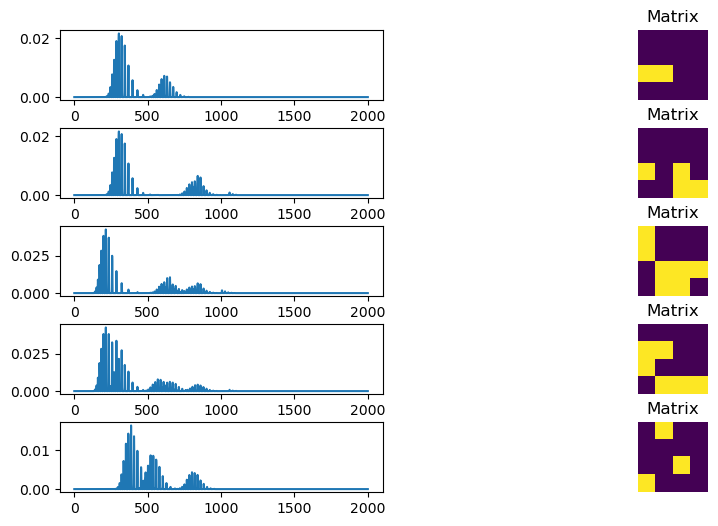

In [15]:
import matplotlib.pyplot as plt

num_examples = 5  # Number of examples to plot

# Create a figure with appropriate size
fig, axs = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 6))

# Iterate over the examples
for i in range(num_examples):
    # Plot the spectrum
    axs[i, 0].plot(spectral_data[i])

    # Plot the associated matrix
    axs[i, 1].imshow(Interaction_matrices[i], cmap='viridis')
    axs[i, 1].set_title('Matrix')
    axs[i, 1].axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Show the plot
plt.show()

In [18]:
for matrix in Interaction_matrices: # forgot to zero out the diagonal
    matrix[0,0] = 0

In [19]:
# flattening and stacking interaction matrices
flattened_matrices = [matrix.flatten() for matrix in Interaction_matrices] # storing in an array
flattened_matrices = torch.stack(flattened_matrices) # stacking the array
print(flattened_matrices.shape)
print(flattened_matrices[0]) # example to see the shape

torch.Size([100, 16])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.])


In [20]:
X_train, X_test, y_train, y_test = train_test_split(spectral_data, flattened_matrices, test_size=0.2, random_state=42)

In [21]:
import torch 
from torch.utils.data import DataLoader, TensorDataset


batch_size = 32 ## 512 is a good number for now. ?? 256 also worked well.

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)


test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
import torch.nn as nn

class SpectralNet(nn.Module):
    def __init__(self):
        super(SpectralNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2001, 1024), # 2001 is the number of features in the spectra data
            nn.ReLU(),
            nn.Linear(1024, 512), 
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),  # Added layer
            nn.ReLU(),  # Added activation function
            nn.Linear(64, 16), # 16 is the number of features in the flattened interaction matrix (multilabel classification)
            nn.Sigmoid() # sigmoid activation function for multilabel classification 
        )
    def forward(self, x):
        return self.model(x)
    


In [50]:
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR

model = SpectralNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001) # lr = 0.001 works well
scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=2000, mode='triangular')

#criterion = AsymmetricLossMultiLabel(gamma_neg=4, gamma_pos=0, clip=1.0) 
criterion = nn.BCELoss() # binary cross entropy loss for multilabel classification


In [51]:
# function to calculate the gradient norms
def compute_gradient_norms(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    return total_norm

In [52]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb
from sklearn.metrics import f1_score, hamming_loss, precision_score, recall_score, jaccard_score

def train(model, train_loader, optimizer, scheduler, criterion, num_epochs):
    train_epoch_losses = []

    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        train_loss = 0.0
        y_true_list = []
        y_pred_list = []

        
        for batch in train_loader:
            X, y = batch
            
            # Forward pass
            y_pred = model(X)
            loss = criterion(y_pred, y)
            
            # Accumulate batch loss
            train_loss += loss.item()
            
            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            gradient_norm = compute_gradient_norms(model)
            optimizer.step()

            # Step the scheduler
            scheduler.step()

            # Append the predictions and true labels for the epoch

            binary_predictions = (y_pred > 0.5).float() # hard thresholding
            y_pred_list.append(binary_predictions.cpu().numpy())
            y_true_list.append(y.cpu().numpy())
        
    

        # Average loss for the epoch
        train_loss /= len(train_loader)
        train_epoch_losses.append(train_loss)

        y_true = np.concatenate(y_true_list, axis=0)
        y_pred = np.concatenate(y_pred_list, axis=0)

        y_true = y_true.astype(int)
        y_pred = y_pred.astype(int)

        hamming_loss_value = hamming_loss(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
        jaccard_score_value = jaccard_score(y_true, y_pred, average='micro')

                    
        print(f"Epoch [{epoch+1}/{num_epochs}],jacquard_loss:{jaccard_score_value}, hammingloss: {hamming_loss_value:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")     

        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

        wandb.log({
            "Train Loss": train_loss,
            "Gradient Norm": gradient_norm,
            "Train Hamming Loss": hamming_loss_value,
            "Train Precision": precision,
            "Train Recall": recall,
            "Train F1": f1,
            "Train Jaccard Score": jaccard_score_value

        })
        if (epoch + 1) % 10 == 0:
                state = {
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'loss': train_loss,
                }
                torch.save(state, "binary_model.pth") ## save the model every x epochs
                print("Saved model to:", "binary_model.pth")
    



    wandb.finish()
    return train_epoch_losses

In [54]:

import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="4x4_matrices",
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "ANN",
    "dataset": "small_matrices.pkl",
    "batch_size": 32,
    "optimizer": "Adam",
    "loss_function": "BCELoss",
    "scheduler": "CyclicLR",
    "max_lr": 1e-5,
    "base_lr": 1e-3,
    })
train_epoch_losses = train(model, train_loader, optimizer, scheduler, criterion, num_epochs=3000)

KeyboardInterrupt: 

In [35]:
def evaluate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []
    

    with torch.no_grad():
        for batch in loader:
            X, y = batch
            
            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(y.cpu().numpy())
            val_loss /= len(loader)
    
    print(f"Loss: {val_loss:.4f}")

    return y_true, y_pred

y_trueTrain, y_predTrain = evaluate(model, train_loader, criterion)
y_trueTest, y_predTest = evaluate(model, test_loader, criterion)




Loss: 0.0373
Loss: 0.7140


In [36]:

y_pred_train_reshaped = torch.tensor(y_predTrain).reshape(-1, 4, 4)
y_pred_test_reshaped = torch.tensor(y_predTest).reshape(-1, 4, 4)

y_true_train_reshaped = torch.tensor(y_trueTrain).reshape(-1, 4, 4)
y_true_test_reshaped = torch.tensor(y_trueTest).reshape(-1, 4, 4)

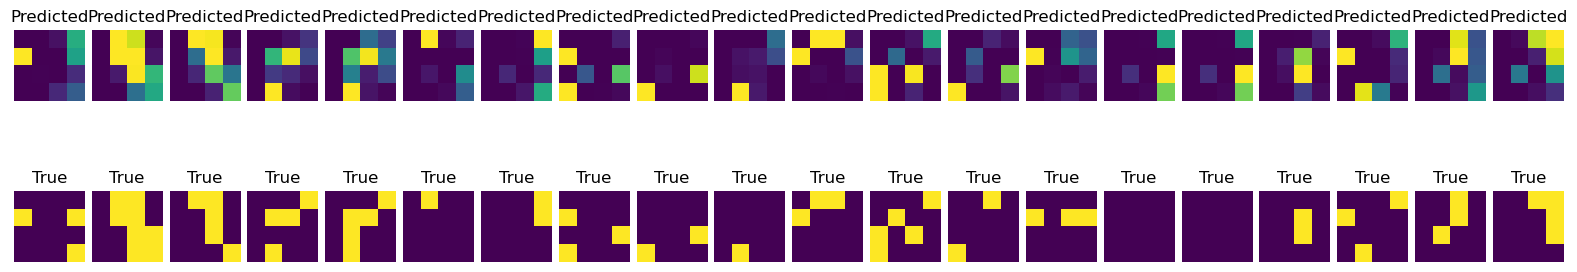

In [37]:
import matplotlib.pyplot as plt

num_images = 20  # Number of images to plot

# Create a figure with appropriate size
fig, axs = plt.subplots(nrows=2, ncols=num_images, figsize=(20, 4))

# Iterate over the images
for i in range(num_images):
    # Plot predicted matrix
    axs[0, i].imshow(y_pred_train_reshaped[i], cmap='viridis')
    axs[0, i].axis('off')
    axs[0, i].set_title('Predicted', fontsize=12)

    # Plot true matrix
    axs[1, i].imshow(y_true_train_reshaped[i], cmap='viridis')
    axs[1, i].axis('off')
    axs[1, i].set_title('True', fontsize=12)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()